# TripAdvisor Scraper

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
import re
from selenium.webdriver.chrome.options import Options
import seaborn as sns

## Scrape Restaurant URLs and Restaurant Details and Clean Data

Fields to be scraped:
- name
- overall average rating
- no of reviews
- ranking
- total restaurants / ranking out of
- price range
- cuisines

In [2]:
class TripAdvisorScraper:
    
    def __init__(self, base_url, search_url):
        self.base_url = base_url
        self.search_url = search_url
        
    def get_restaurant_links(self):
        pattern = re.compile(r"Restaurant_Review.*")
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        chrome_driver = webdriver.Chrome(options=chrome_options)
        chrome_driver.get(search_url)
        url_page_content = chrome_driver.page_source
        soup = BeautifulSoup(url_page_content, "html.parser")
        restaurant_links = set()
        for link in soup.find_all("a", href=pattern):
            restaurant_links.add(base_url + link.get("href"))
        self.restaurant_links = restaurant_links
        print("Total unique links obtained: ", len(self.restaurant_links))
        
    def get_all_restaurant_details(self):
        all_rest_details = []
        for restaurant_url in self.restaurant_links:
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            chrome_driver = webdriver.Chrome(options=chrome_options)
            chrome_driver.get(restaurant_url)
            response = chrome_driver.page_source
            soup = BeautifulSoup(response, "html.parser")
            name = soup.find("h1", class_="HjBfq")
            avg_rating = soup.find("span", class_="ZDEqb")
            num_reviews = soup.find("a", class_="IcelI")
            ranking = None
            tmp = soup.find("div", class_="cNFlb")
            if tmp:
                tmp = tmp.find("b")
                if tmp:
                    tmp = tmp.find("span")
                    if tmp:
                        ranking = tmp
            ranking_out_of = soup.find("div", class_="cNFlb")
            tmp = soup.find("div", class_="BMlpu")
            tmp1, tmp2 = [], []
            if tmp:
                tmp1 = tmp.find_all(class_=["div", "tbUiL", "b"])
                tmp2 = tmp.find_all("div", class_="SrqKb")
            price_range = None
            cuisines = None
            for t1, t2 in zip(tmp1, tmp2):
                if t1.text.lower() == "price range":
                    price_range = t2
                elif t1.text.lower() == "cuisines":
                    cuisines = t2

            all_rest_details.append({
                "name": name.text if name else None,
                "avg_rating": avg_rating.text if avg_rating else None,
                "num_reviews": num_reviews.text if num_reviews else None,
                "ranking": ranking.text if ranking else None,
                "ranking_out_of": ranking_out_of.text if ranking_out_of else None,
                "price_range": price_range.text if price_range else None,
                "cuisines": cuisines.text if cuisines else None
            })
        self.all_rest_details = all_rest_details
        
    def clean_data(self):
        df = pd.DataFrame(self.all_rest_details)
        
        # Delete rows where all column values are None
        df = df.dropna(how='all')
        
        df['avg_rating'] = df['avg_rating'].str.strip()
        df['avg_rating'] = pd.to_numeric(df['avg_rating'], errors='coerce').astype('Float64')
        
        def clean_num_reviews(elem):
            if elem:
                elem = int(elem.split()[0].replace(",", ""))
            return elem
        df['num_reviews'] = df['num_reviews'].apply(clean_num_reviews)
        
        def clean_ranking(elem):
            if elem:
                elem = int(elem.split('#')[1].replace(",", ""))
            return elem
        df['ranking'] = df['ranking'].apply(clean_ranking)

        def get_ranking_type(elem):
            if elem:
                elem = " ".join(elem.split()[3:])
            return elem
        df['ranking_type'] = df['ranking_out_of'].apply(get_ranking_type) 

        def clean_ranking_out_of(elem):
            if elem:
                elem = int(elem.split()[2].replace(",", ""))
            return elem
        df['ranking_out_of'] = df['ranking_out_of'].apply(clean_ranking_out_of) 
        
        def get_price_range_start(elem):
            if elem:
                elem = int(elem.split()[0].replace("$", "").replace(",", ""))
            return elem
        df['price_range_start_usd'] = df['price_range'].apply(get_price_range_start)

        def get_price_range_end(elem):
            if elem:
                elem = int(elem.split()[-1].replace("$", "").replace(",", ""))
            return elem
        df['price_range_end_usd'] = df['price_range'].apply(get_price_range_end)
        
        df = df.drop('price_range', axis=1)
        
        df['cuisines'].str.strip()
        
        df = df.drop_duplicates().reset_index(drop=True)
        
        self.cleaned_df = df.copy()

In [3]:
base_url = "https://www.tripadvisor.com"
search_url = "https://www.tripadvisor.com/Restaurants-g60811-Baltimore_Maryland.html"
baltimore_scraper = TripAdvisorScraper(base_url, search_url)

In [4]:
baltimore_scraper.get_restaurant_links()

Total unique links obtained:  88


In [5]:
baltimore_scraper.get_all_restaurant_details()

In [6]:
baltimore_scraper.clean_data()

In [7]:
cleaned_scraped_df = baltimore_scraper.cleaned_df.copy()

In [8]:
cleaned_scraped_df

,name,avg_rating,num_reviews,ranking,ranking_out_of,cuisines,ranking_type,price_range_start_usd,price_range_end_usd
0,"Miss Shirley's Cafe, Roland Park",4.5,1449,13,957,American,Restaurants in Baltimore,6.0,25.0
1,Blue Moon Cafe,4.5,920,16,957,None,Restaurants in Baltimore,NaN,NaN
2,Thames Street Oyster House,4.5,2156,5,957,"American, Bar, Seafood",Restaurants in Baltimore,NaN,NaN
3,The Capital Grille,4.5,654,6,957,None,Restaurants in Baltimore,NaN,NaN
4,Southside Diner,4.5,48,88,957,None,Restaurants in Baltimore,NaN,NaN
5,Dalesio's of Little Italy Restaurant,4.5,1016,7,957,"Italian, Northern-Italian",Restaurants in Baltimore,18.0,29.0
6,Ouzo Bay,4.5,465,27,957,None,Restaurants in Baltimore,NaN,NaN
7,LP Steamers,4.5,681,19,957,None,Restaurants in Baltimore,NaN,NaN
8,The Helmand,4.5,613,8,957,"Middle Eastern, Afghan",Restaurants in Baltimore,30.0,30.0
9,Faidley's Seafood,4.5,640,2,89,"American, Seafood",Quick Bites in Baltimore,NaN,NaN


## Data Visualization and Analysis

In [9]:
print("Dataset Summary:")
print(cleaned_scraped_df.info())

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   51 non-null     object 
 1   avg_rating             51 non-null     Float64
 2   num_reviews            51 non-null     int64  
 3   ranking                51 non-null     int64  
 4   ranking_out_of         51 non-null     int64  
 5   cuisines               30 non-null     object 
 6   ranking_type           51 non-null     object 
 7   price_range_start_usd  18 non-null     float64
 8   price_range_end_usd    18 non-null     float64
dtypes: Float64(1), float64(2), int64(3), object(3)
memory usage: 3.8+ KB
None


**Observations:** The dataset comprises 51 entries with various restaurant attributes. There are 51 non-null entries for restaurant names, average ratings, number of reviews, rankings, and ranking out of totals. However, 33 entries lack price range information, indicating missing data in this aspect. Additionally, there are 21 entries with missing cuisine details.

In [10]:
print("\nDescriptive Statistics:")
print(cleaned_scraped_df.describe())


Descriptive Statistics:
       avg_rating  num_reviews    ranking  ranking_out_of  \
count        51.0    51.000000  51.000000       51.000000   
mean     4.460784   724.784314  15.333333      672.764706   
std      0.196039   619.894356  18.249018      409.459673   
min           4.0    48.000000   1.000000       21.000000   
25%           4.5   294.000000   3.000000       99.500000   
50%           4.5   513.000000  11.000000      957.000000   
75%           4.5   942.000000  20.000000      957.000000   
max           5.0  3195.000000  88.000000      957.000000   

       price_range_start_usd  price_range_end_usd  
count              18.000000            18.000000  
mean               20.833333            39.055556  
std                13.342766            31.886697  
min                 5.000000            10.000000  
25%                10.500000            26.000000  
50%                19.000000            30.000000  
75%                30.000000            39.000000  
max      

**Observations:** The average restaurant rating (avg_rating) is approximately 4.46, with a range from 4.0 to 5.0. The number of reviews (num_reviews) varies widely, from 48 to 3195, with an average of around 724.78 reviews per restaurant. Restaurant rankings (ranking) range from 1 to 88. Price range data is available for 18 out of 48 entries, with starting prices ranging from \\$5 to \\$50 and average starting price at approximately \\$20.83, while ending prices range from \\$10 to \\$150, with an average ending price of about \\$39.06.

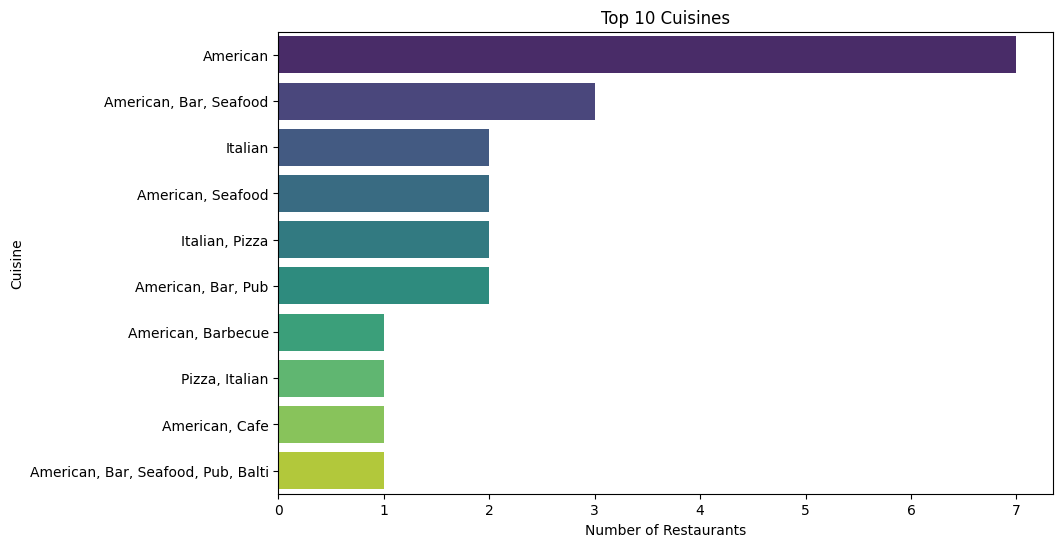

In [11]:
cuisine_counts = cleaned_scraped_df['cuisines'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=cuisine_counts.head(10), y=cuisine_counts.head(10).index, palette="viridis")
plt.title("Top 10 Cuisines")
plt.xlabel("Number of Restaurants")
plt.ylabel("Cuisine")
plt.show()

**Observations:** We can see that American cuisine holds the highest popularity among restaurants in Baltimore, Maryland, with Italian cuisine following closely as the second most favored choice.

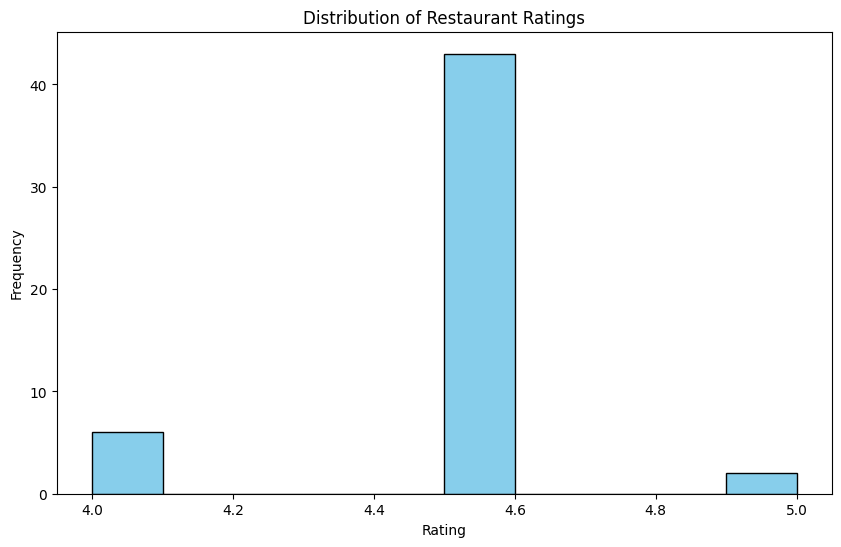

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_scraped_df["avg_rating"], bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Restaurant Ratings")
plt.show()

**Observations:** It's apparent that the majority of ratings cluster around the 4.5 range, while relatively fewer restaurants receive ratings of 4 or 5.

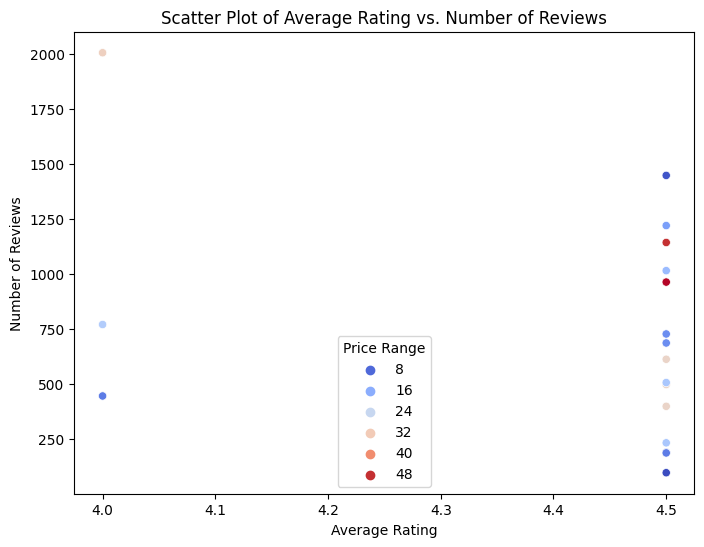

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='avg_rating', y='num_reviews', data=cleaned_scraped_df, hue='price_range_start_usd', palette='coolwarm')
plt.title("Scatter Plot of Average Rating vs. Number of Reviews")
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")
plt.legend(title="Price Range")
plt.show()

**Observations:**
- **Popularity:** Products or services with higher ratings tend to have more reviews, indicating they may be more popular.
- **Price and Reviews:** There's no clear trend between price range and number of reviews or ratings, suggesting price may not significantly impact these factors.
- **Rating Distribution:** Most ratings are high, between 4.2 and 4.5, showing general customer satisfaction.
- **Outliers:** Some items have an exceptionally high number of reviews.

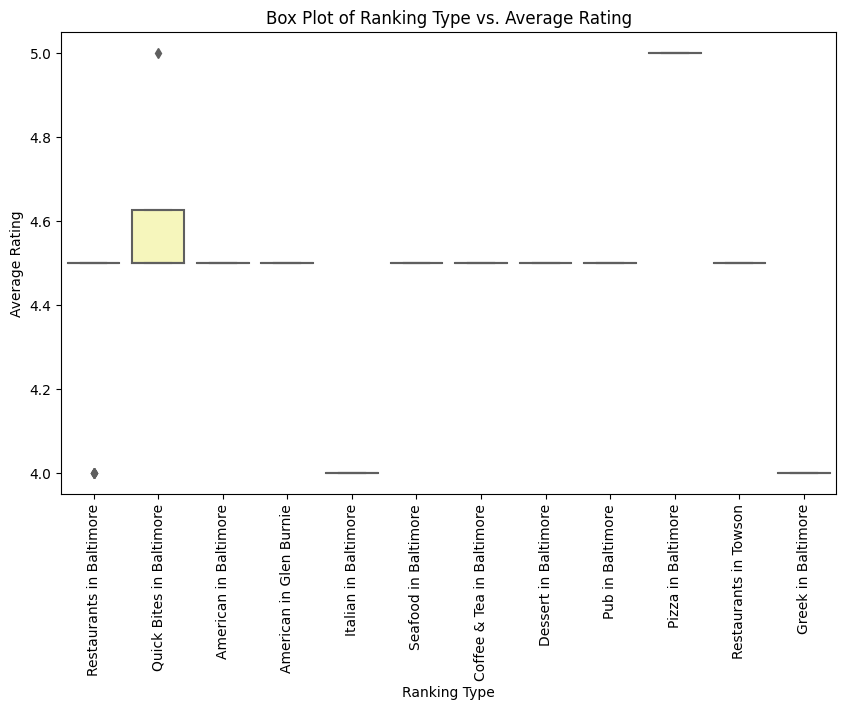

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ranking_type', y='avg_rating', data=cleaned_scraped_df, palette="Set3")
plt.title("Box Plot of Ranking Type vs. Average Rating")
plt.xlabel("Ranking Type")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.show()

**Observations:** The box plot shows varying average ratings for restaurant types in Baltimore, with Quick Bites displaying the widest rating range and significant outliers.

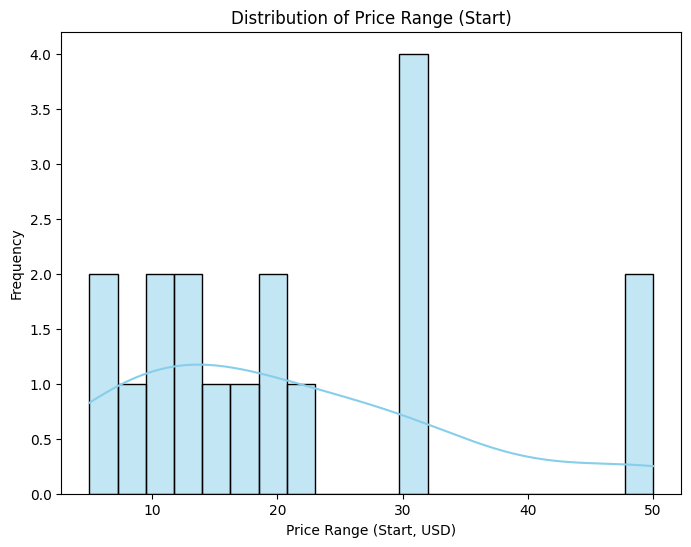

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(cleaned_scraped_df['price_range_start_usd'], kde=True, bins=20, color='skyblue')
plt.title("Distribution of Price Range (Start)")
plt.xlabel("Price Range (Start, USD)")
plt.ylabel("Frequency")
plt.show()

**Observations:** The initial price range spans from \\$10 to \\$50, with the \\$30 range emerging as the most prevalent starting point.

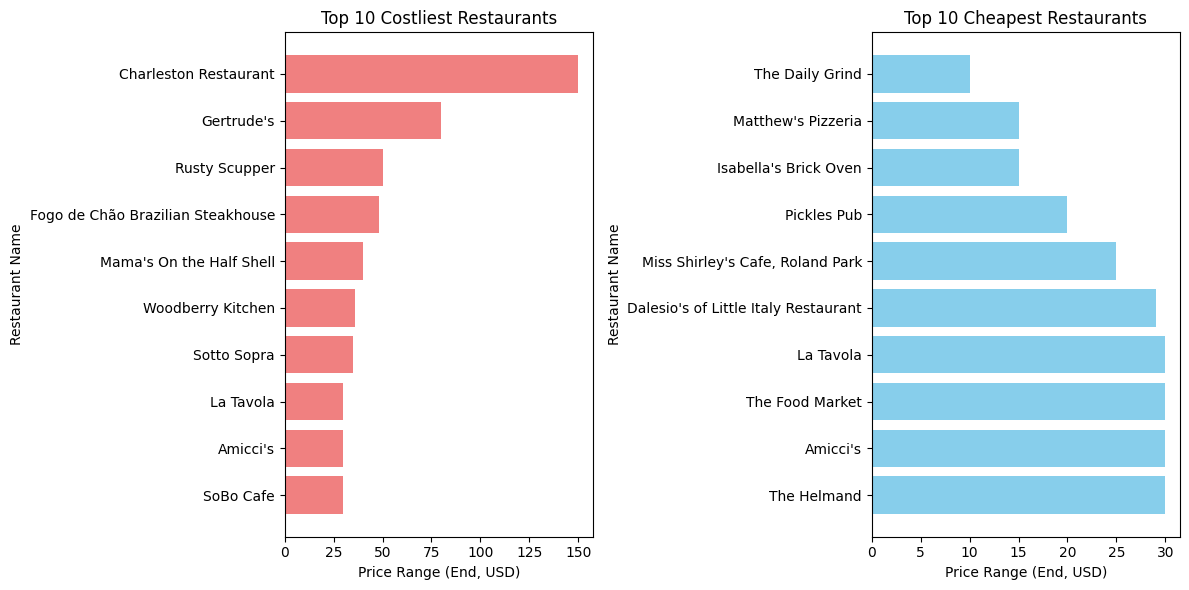

In [16]:
top_10_costliest = cleaned_scraped_df.sort_values(by='price_range_end_usd', ascending=False).head(10)
top_10_costliest = top_10_costliest.sort_values(by='price_range_end_usd', ascending=True)

top_10_cheapest = cleaned_scraped_df.sort_values(by='price_range_end_usd', ascending=True).head(10)
top_10_cheapest = top_10_cheapest.sort_values(by='price_range_end_usd', ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].barh(top_10_costliest['name'], top_10_costliest['price_range_end_usd'], color='lightcoral')
axes[0].set_title('Top 10 Costliest Restaurants')
axes[0].set_xlabel('Price Range (End, USD)')
axes[0].set_ylabel('Restaurant Name')

axes[1].barh(top_10_cheapest['name'], top_10_cheapest['price_range_end_usd'], color='skyblue')
axes[1].set_title('Top 10 Cheapest Restaurants')
axes[1].set_xlabel('Price Range (End, USD)')
axes[1].set_ylabel('Restaurant Name')

plt.tight_layout()

plt.show()

**Observations:**  
The top 5 costliest restaurants are: 
- Charleston Restaurant
- Gertrude's
- Rusty Scupper
- Fogo de Chão Brazilian Steakhouse
- Mama's On the Half Shell
 
The top 5 cheapest restaurants are:
- The Daily Grind
- Matthew's Pizzeria
- Isabella's Brick Oven
- Pickles Pub
- Miss Shirley's Cafe, Roland Park

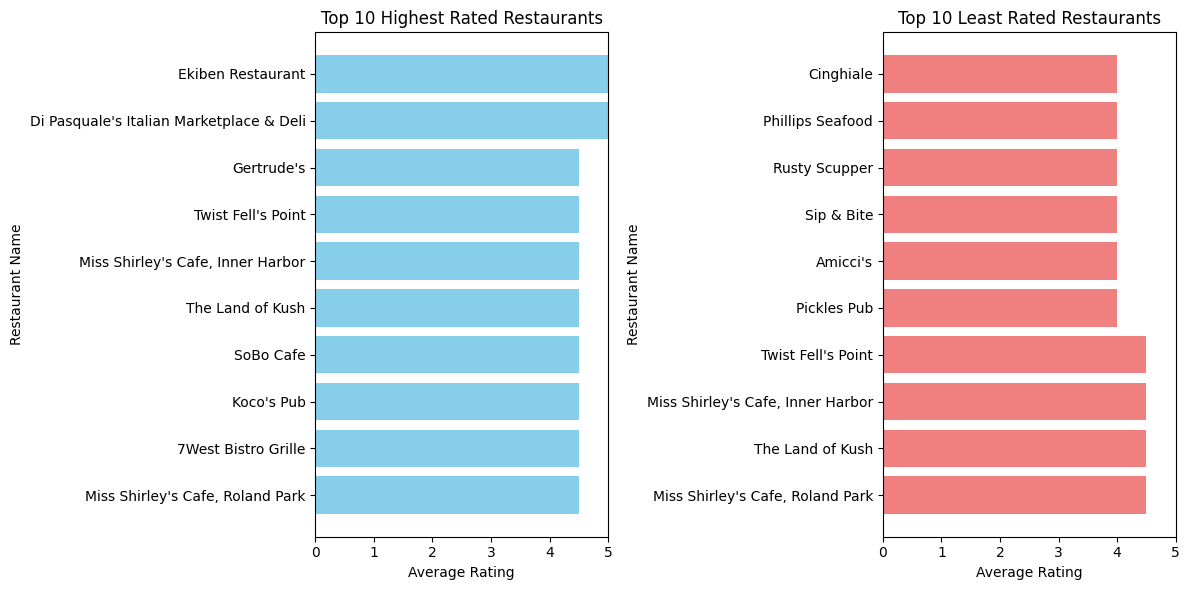

In [17]:
top_10_highest_rated = cleaned_scraped_df.sort_values(by='avg_rating', ascending=False).head(10)
top_10_highest_rated = top_10_highest_rated.sort_values(by='avg_rating', ascending=True)

top_10_least_rated = cleaned_scraped_df.sort_values(by='avg_rating', ascending=True).head(10)
top_10_least_rated = top_10_least_rated.sort_values(by='avg_rating', ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].barh(top_10_highest_rated['name'], top_10_highest_rated['avg_rating'], color='skyblue')
axes[0].set_title('Top 10 Highest Rated Restaurants')
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Restaurant Name')
axes[0].set_xlim(0, 5)

axes[1].barh(top_10_least_rated['name'], top_10_least_rated['avg_rating'], color='lightcoral')
axes[1].set_title('Top 10 Least Rated Restaurants')
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Restaurant Name')
axes[1].set_xlim(0, 5)
plt.tight_layout()
plt.show()


**Observations:**  
The top 5 highest rated restaurants are: 
- Ekiben Restaurant
- Di Pasquale's Italian Marketplace & Deli
- Gertrude's
- Twist Fell's Point
- Miss Shirley's Cafe, Inner Harbor
 
The top 5 least rated restaurants are:
- Cinghiale
- Phillips Seafood
- Rusty Scupper
- Sip & Bite
- Amicci's